In [1]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier,BaggingRegressor

# bagging

In [2]:
# 实验数据

from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
y = bc.target
X = pd.DataFrame.from_records(data=bc.data, columns=bc.feature_names)

# 转化为df
df = X
df['target'] = y

In [3]:
# 只取前2个特征
cols = [
    'mean radius','mean texture',
]
X_train, X_test, y_train, y_test = train_test_split(X[cols],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [4]:
tree = DecisionTreeClassifier(max_depth=None, random_state=42)

In [7]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=200,
                        max_samples=0.9,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=42)

In [9]:

tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracy: {:.3f}/{:.3f}'.format(
    acc_train, acc_test))

Decision tree train/test accuracy: 1.000/0.781


In [10]:
bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print('Bagging tree train/test accuracy: {:.3f}/{:.3f}'.format(
    acc_train, acc_test))

Bagging tree train/test accuracy: 1.000/0.860


In [11]:
from sklearn.datasets import make_classification
Xt, yt = make_classification(n_samples=1000,
                           n_features=7,
                           n_redundant=1,
                           n_informative=6,
                           n_clusters_per_class=3,
                           n_classes=2,
                           random_state=42)

In [12]:
clf_lr = LogisticRegression(solver='liblinear',
                            random_state=42,C=10)  #class_weight="balanced",1e9

bag = BaggingClassifier(base_estimator=clf_lr,
                        n_estimators=200,
                        max_samples=0.5,
                        #max_features=1,
                        random_state=42)

In [13]:
for clf, label in zip([clf_lr, bag], ['Logistic','Bagging Logistic']):
    scores = cross_val_score(estimator=clf,
                             X=Xt,
                             y=yt,
                             cv=10,
                             scoring='roc_auc')
    print("AUC:{:.2} (+/- {:.2}) [{}]".format(scores.mean(), scores.std(),
                                              label))

AUC:0.84 (+/- 0.031) [Logistic]
AUC:0.84 (+/- 0.031) [Bagging Logistic]


# boosting

## gbdt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

n = 150
X = np.linspace(-1, 1, n)
y = X**2 + np.random.normal(loc=0, scale=0.1, size=n)
X = X.reshape(-1, 1)

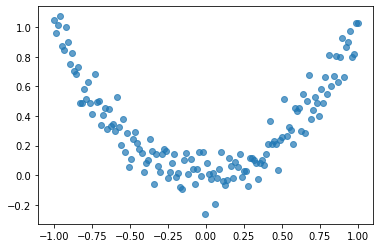

In [2]:
plt.scatter(X, y, alpha=0.7)
plt.show()

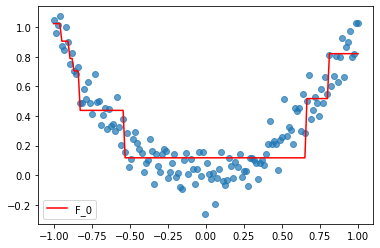

In [3]:
from sklearn.tree import DecisionTreeRegressor

dtr1 = DecisionTreeRegressor(max_depth=3)
dtr1.fit(X, y)

plt.figure()
plt.scatter(X, y, alpha=0.7)
plt.plot(X, dtr1.predict(X), 'r', label='F_0')
plt.legend(loc=3)
plt.show()

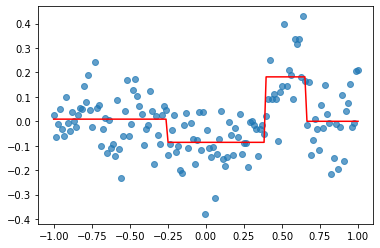

In [4]:

y2 = y - dtr1.predict(X)
dtr2 = DecisionTreeRegressor(max_depth=2)
dtr2.fit(X, y2)

plt.scatter(X, y2, alpha=0.7)
plt.plot(X, dtr2.predict(X), 'r')
plt.show()

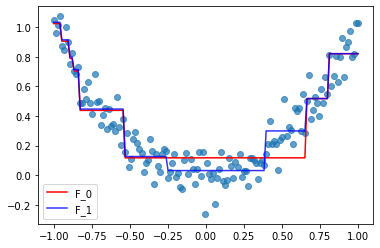

In [5]:
F_0 = dtr1.predict(X)
f_1 = dtr2.predict(X)

F_1 = F_0 + f_1
plt.scatter(X, y, alpha=0.7)
plt.plot(X, F_0, 'r', label='F_0')
plt.plot(X, F_1, 'b', label='F_1', alpha=0.8)
plt.legend()
plt.show()

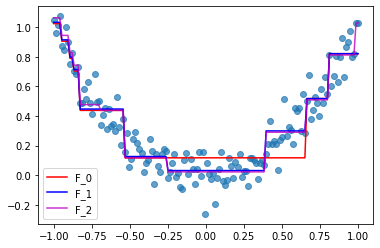

In [7]:
y3 = y2 - dtr2.predict(X)
dtr3 = DecisionTreeRegressor(max_depth=2)
dtr3.fit(X, y3)

f_2 = dtr3.predict(X)
F_2 = F_0 + f_1 + f_2

plt.scatter(X, y, alpha=0.7)
plt.plot(X, F_0, 'r', label='F_0')
plt.plot(X, F_1, 'b', label='F_1')
plt.plot(X, F_2, 'm', label='F_2', alpha=0.8)
plt.legend()
plt.show()

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gb.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

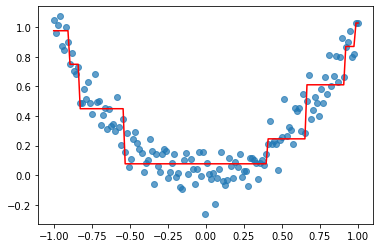

In [9]:
plt.figure()
plt.scatter(X, y, alpha=0.7)
plt.plot(X, gb.predict(X), 'r')
plt.show()

## boosting解析

In [12]:
# 同bagging 一样的例子
import numpy as np
np.random.seed(42)
# 构造500个数据点
n = 500
X = np.array([i / n for i in range(n + 1)])
# 构造一个包含方差为 0.01 的噪音数据
y = np.array([i + np.random.normal(scale=0.1) for i in X])


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Fit regression model
params = {
    'n_estimators': 50,
    'max_depth': 1,
    'learning_rate': 0.5,
    'loss': 'ls'
}
clf = GradientBoostingRegressor(**params)
clf.fit(X_train.reshape(-1, 1), y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.5, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
# Fit regression model
params = {
    'n_estimators': 50,
    'max_depth': 1,
    'learning_rate': 0.5,# 'learning_rate': 1, 有过拟合的倾向，train-test 的mse差异比较大
    'loss': 'ls'
}
clf = GradientBoostingRegressor(**params)
clf.fit(X_train.reshape(-1, 1), y_train)


mse = np.zeros((params['n_estimators'], ), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test.reshape(-1, 1))):
    mse[i] = mean_squared_error(y_test, y_pred)
    
mse_train = np.zeros((params['n_estimators'], ), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_train.reshape(-1, 1))):
    mse_train[i] = mean_squared_error(y_train, y_pred)
    

Text(0, 0.5, 'MSE')

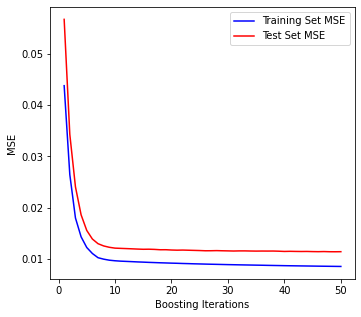

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(params['n_estimators']) + 1, mse_train, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, mse, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')